**SERVICIO EDUCACIONAL HOGAR Y SALUD DEL NORTE**

**INDICADOR: Cantidad promedio mensual de material inventariado por sede**


Christian Ovalle

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


**1. PREPARACIÓN DE LA DATA**

  En esta sección se preparan los datos necesarios para aplicar el modelo. Se realiza la instalación de bibliotecas, la lectura del archivo Excel, la transformación de los datos, la aplicación de técnicas pertinentes de preprocesamiento de datos y la separación de los datos en conjuntos de entrenamiento y prueba.

In [ ]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import zscore

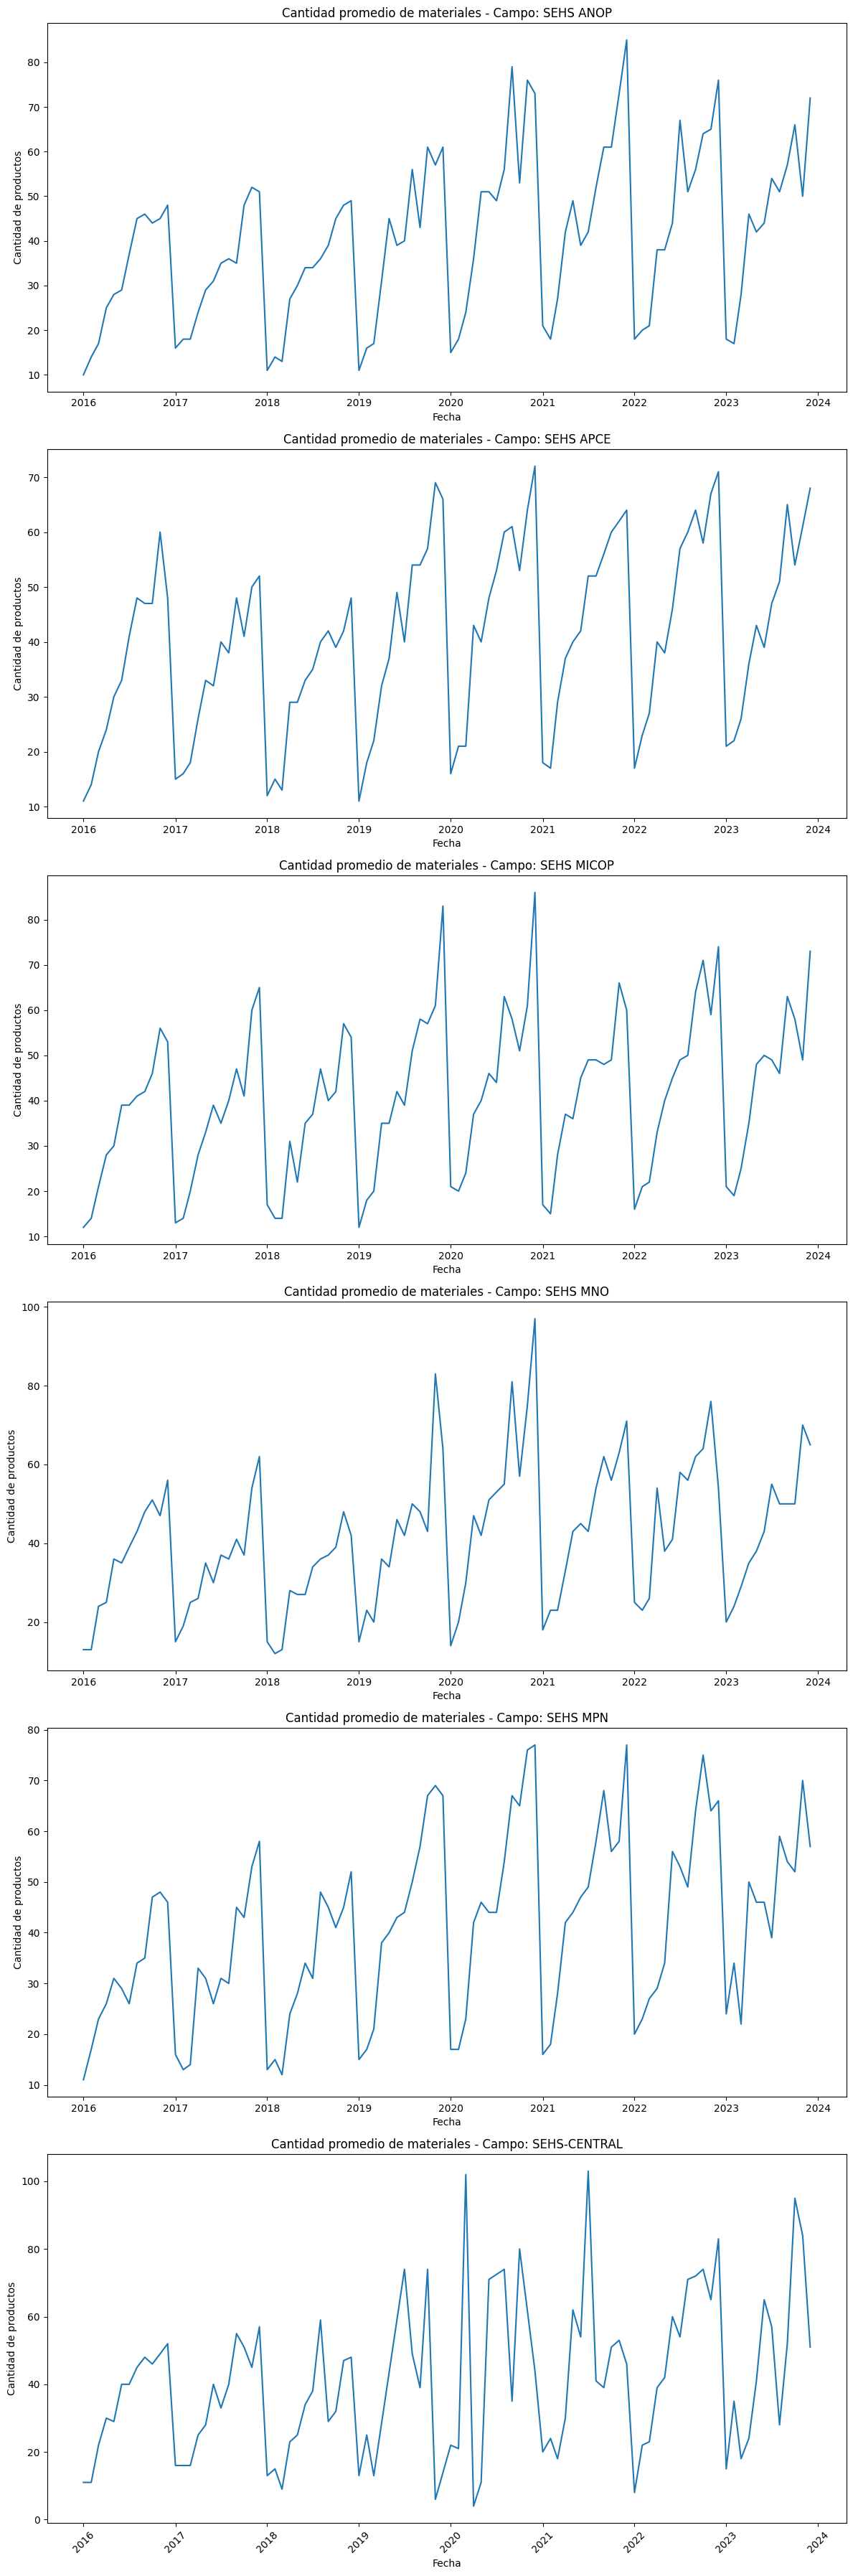

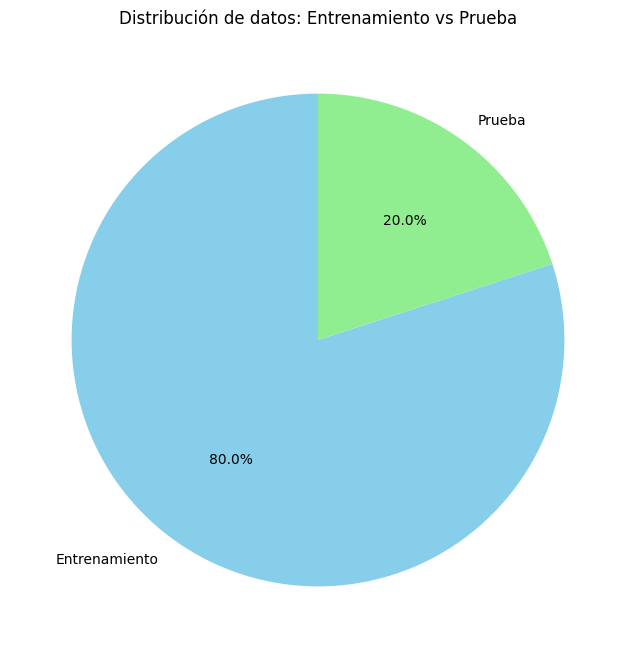

In [ ]:
# Cargar el dataset
file_path = "/content/Datasets_Base_familias.xlsx"
dataset = pd.read_excel(file_path)

# Preparación de los datos
data = pd.DataFrame()
data['campo'] = dataset['campo']
data['cantidad'] = dataset['Cantidad']
data['fecha'] = dataset['fecha'].dt.to_period('M')

# Agrupar las ventas por categoría y año, calculando el promedio de cantidad
df_promedio_campo = data.groupby(['campo', 'fecha'])['cantidad'].mean().reset_index()
df_promedio_campo['cantidad'] = df_promedio_campo['cantidad'].round()
df_promedio_campo['fecha'] = pd.to_datetime(df_promedio_campo['fecha'].astype(str), format='%Y-%m')

# Manejo de valores atípicos
z_scores = zscore(df_promedio_campo['cantidad'])
df_promedio_campo = df_promedio_campo[(np.abs(z_scores) < 3)]

# Convertir las categorías a variables dummy
df_encoded = pd.get_dummies(df_promedio_campo, columns=['campo'])
df_encoded['Year'] = df_encoded['fecha'].dt.year
df_encoded['Month'] = df_encoded['fecha'].dt.month

# Lista única de categorías
campos = df_promedio_campo['campo'].unique()

# Configurar el estilo y crear un subplot para cada campo
fig, axes = plt.subplots(nrows=len(campos), figsize=(12, 6 * len(campos)))

for i, campo in enumerate(campos):
    # Filtrar los datos para el campo actual
    datos_campo = df_promedio_campo[df_promedio_campo['campo'] == campo]

    # Crear gráfica de línea en el subplot correspondiente
    sns.lineplot(data=datos_campo, x='fecha', y='cantidad', ax=axes[i])

    # Configurar título, etiquetas, y estilo
    axes[i].set_title(f'Cantidad promedio de materiales - Campo: {campo}')
    axes[i].set_xlabel('Fecha')
    axes[i].set_ylabel('Cantidad de productos')

# Ajustar el diseño
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Filtrar los datos para el entrenamiento y validación
df_train = df_encoded[df_encoded['Year'] < 2024]
df_test = df_encoded[df_encoded['Year'] >= 2020]

# Definir características (X) y objetivo (y)
X = df_train.drop(columns=['cantidad', 'fecha'])
y = df_train['cantidad']

# Definir X_test con las mismas columnas que X
X_test = df_test[X.columns]
y_test = df_test['cantidad']

# Division aleatoria de los datos para el entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalamiento de las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualización de la división de datos
division_labels = ['Entrenamiento', 'Prueba']
division_sizes = [len(X_train), len(X_test)]

plt.figure(figsize=(8, 8))
plt.pie(division_sizes, labels=division_labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
plt.title('Distribución de datos: Entrenamiento vs Prueba')
plt.show()

**2. SELECCIÓN DE LOS MODELOS**

Se definen los modelos base que participarán en el conjunto (Stacking), como GradientBoosting, Catboost y Random Forest, junto con el meta-modelo, que combina las predicciones de los modelos base. Esta selección se realiza en función de sus capacidades para manejar datos tabulares y ofrecer un buen equilibrio entre rendimiento y flexibilidad.

In [ ]:
# Configuración del modelo de stacking
def build_stacking_model():
    estimators = [
        ('gb', GradientBoostingRegressor()),
        ('catboost', CatBoostRegressor(verbose=0, random_seed=42, loss_function='RMSE')),
        ('rf', RandomForestRegressor())
    ]
    stacking_model = StackingRegressor(
        estimators=estimators,
        final_estimator=LinearRegression(),
        cv=5
    )
    return stacking_model

**3. ENTRENAMIENTO DEL MODELO**

Se entrena cada modelo base utilizando los datos de entrenamiento procesados. Cada modelo aprende patrones en los datos de forma independiente, generando predicciones que más tarde se combinarán para formar el modelo de Stacking.

In [ ]:
# 3. ENTRENAMIENTO DE LOS MODELOS BASE
stacking_model = build_stacking_model()
stacking_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=5,
                  estimators=[('gb', GradientBoostingRegressor()),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7981a2940f10>),
                              ('rf', RandomForestRegressor())],
                  final_estimator=LinearRegression())


**4. OPTIMIZACIÓN DE LOS HIPERPARÁMETROS**

En esta etapa, se optimizan los parámetros de los modelos base utilizando RandomizedSearchCV, lo que permite encontrar combinaciones de hiperparámetros que maximizan el desempeño del modelo. Al final, se seleccionan e imprimen los mejores hiperparámetros para cada modelo base, mejorando la precisión del conjunto.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros encontrados:
{'rf__n_estimators': 50, 'rf__min_samples_split': 20, 'rf__max_depth': 10, 'gb__n_estimators': 100, 'gb__min_samples_split': 20, 'gb__max_depth': 5, 'gb__learning_rate': 0.01, 'catboost__learning_rate': 0.01, 'catboost__iterations': 500, 'catboost__depth': 5}


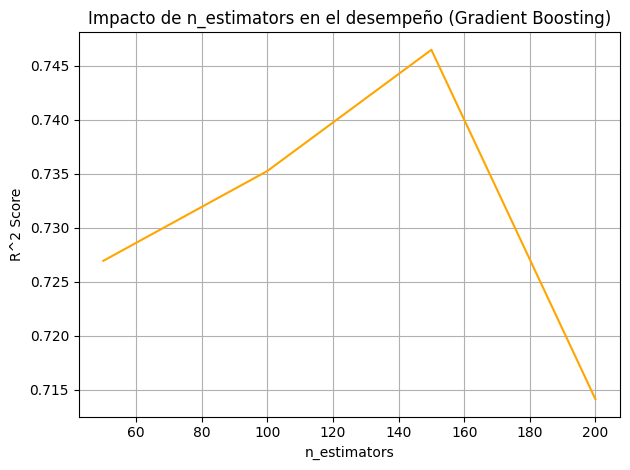

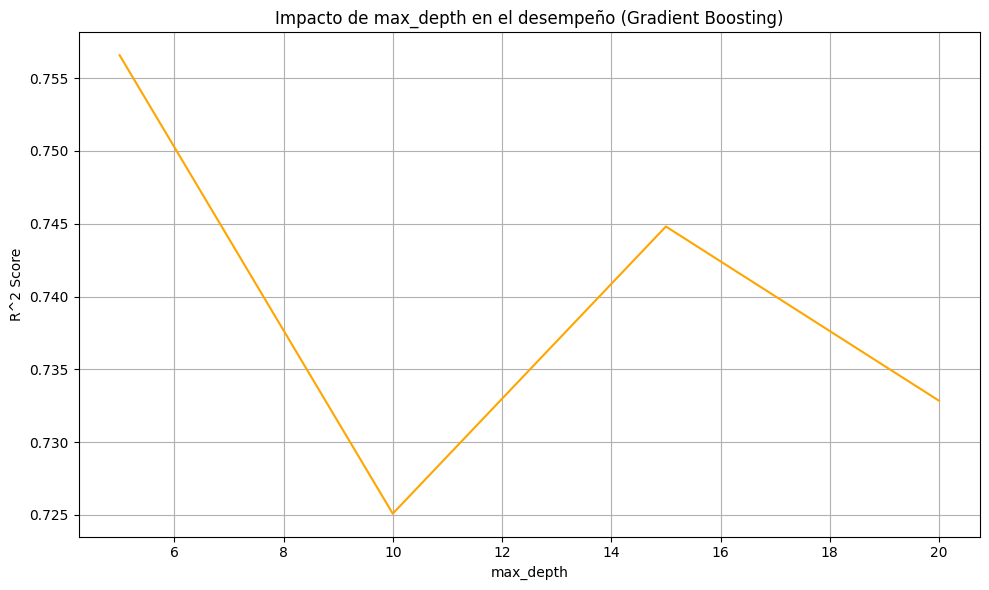

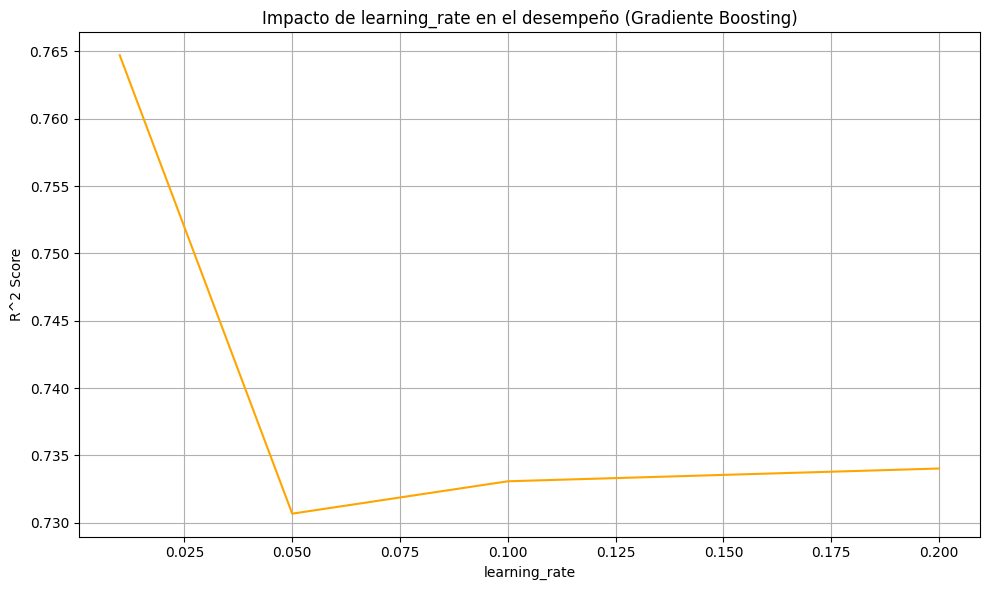

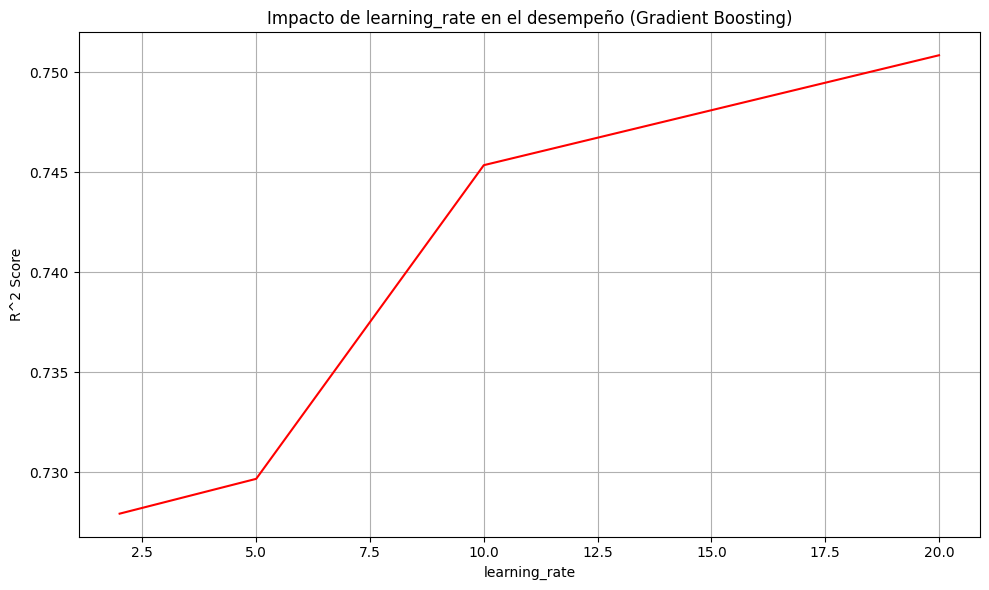

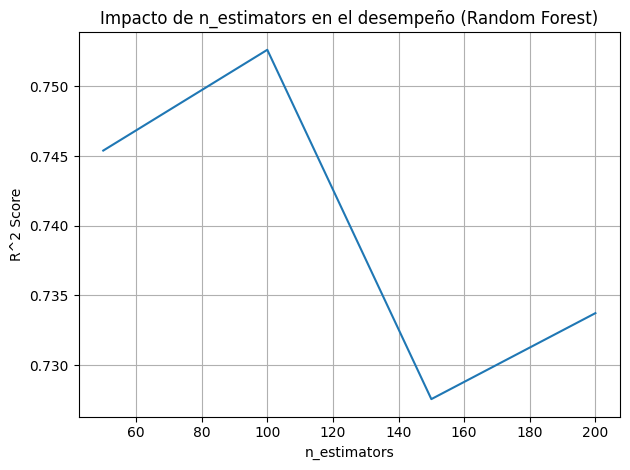

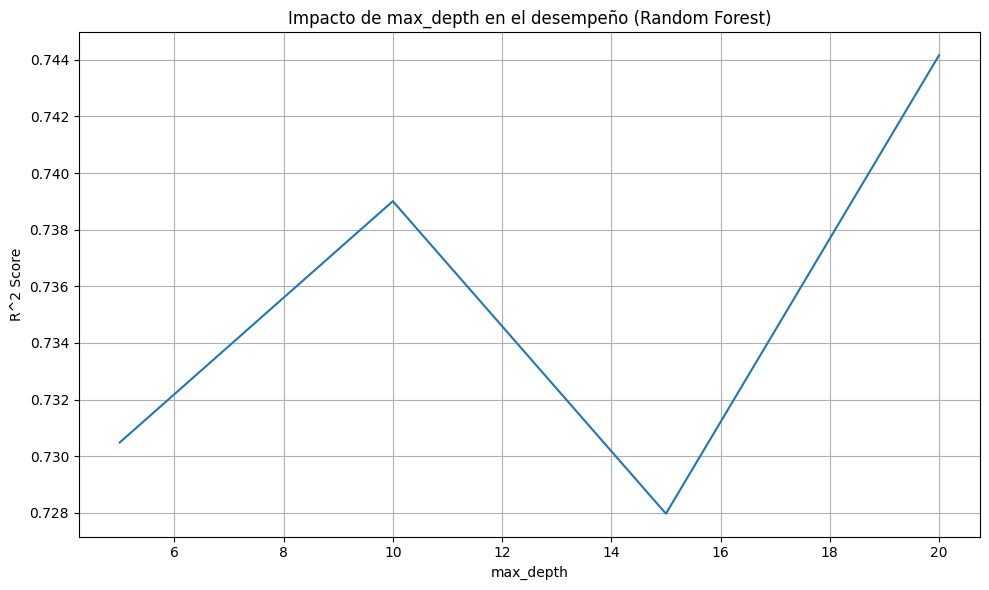

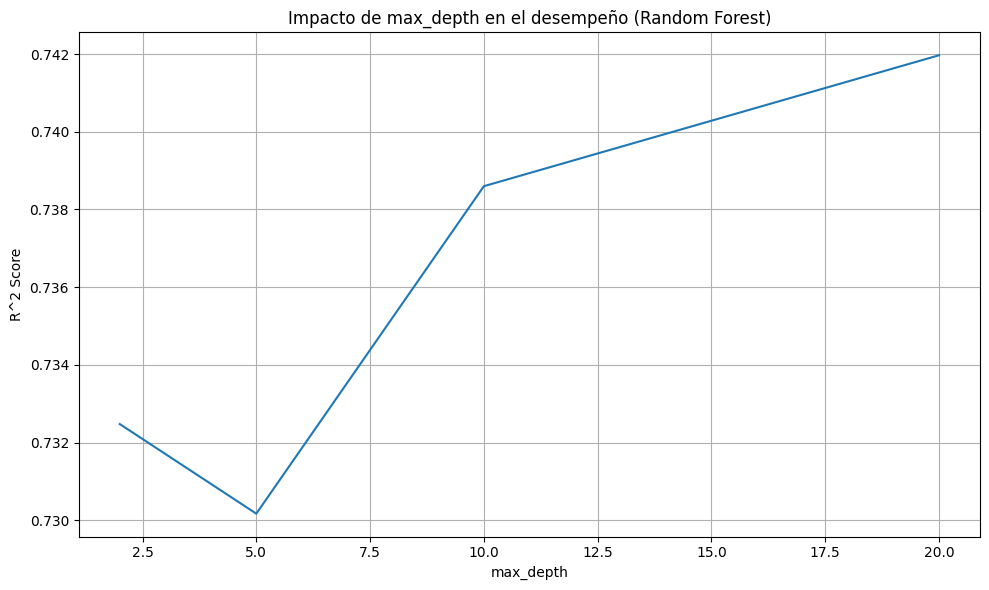

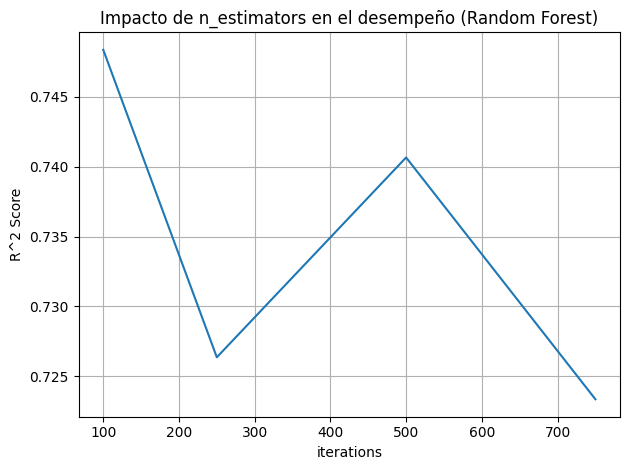

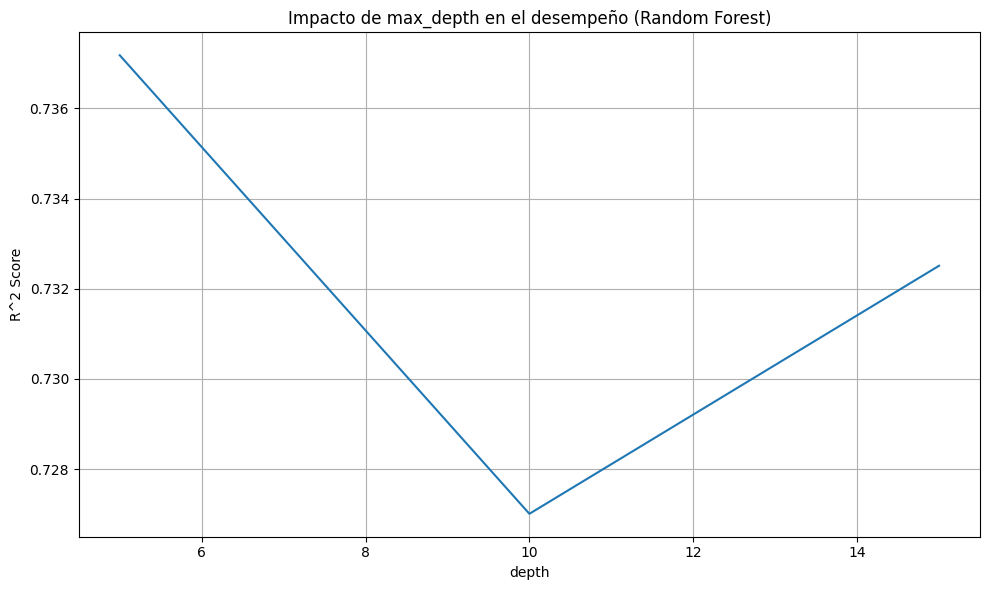

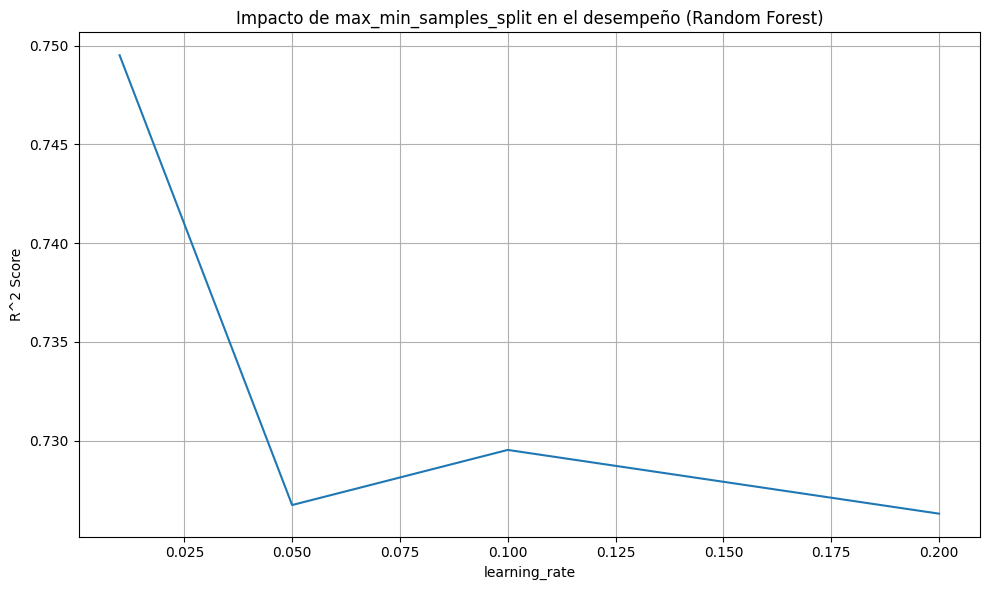

In [ ]:
# 4. OPTIMIZACIÓN DE LOS HIPERPARÁMETROS
param_grid = {
    'catboost__iterations': [100, 250, 500, 750],
    'catboost__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'catboost__depth': [5, 10, 15, 20],
    "gb__n_estimators": [50, 100, 150, 200],
    "gb__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "gb__max_depth": [5, 10, 15, 20],
    "gb__min_samples_split": [2, 5, 10,20],
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [5, 10, 15, 20],
    "rf__min_samples_split": [2, 5, 10, 20]
}
random_search = RandomizedSearchCV(
    estimator=build_stacking_model(),
    param_distributions=param_grid,
    scoring='r2',
    n_iter=20,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_scaled, y_train)
best_model = random_search.best_estimator_

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Resultados del ajuste de hiperparámetros
results = pd.DataFrame(random_search.cv_results_)

# Gráficas de la iteración de los hiperparámetros con respecto a R^2

#Para GradientBoosting
xgb_results = results[["param_gb__n_estimators", "param_gb__learning_rate", "param_gb__max_depth", "param_gb__min_samples_split", "mean_test_score"]]

sns.lineplot(x="param_gb__n_estimators", y="mean_test_score", data=xgb_results, errorbar=None, color='orange')
plt.title("Impacto de n_estimators en el desempeño (Gradient Boosting)")
plt.xlabel("n_estimators")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_gb__max_depth", y="mean_test_score", data=xgb_results, errorbar= None, color='orange')
plt.title("Impacto de max_depth en el desempeño (Gradient Boosting)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_gb__learning_rate", y="mean_test_score", data=xgb_results, errorbar= None,color='orange')
plt.title("Impacto de learning_rate en el desempeño (Gradiente Boosting)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_gb__min_samples_split", y="mean_test_score", data=xgb_results, errorbar= None,color='red')
plt.title("Impacto de learning_rate en el desempeño (Gradient Boosting)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Para Random Forest
rf_results = results[["param_rf__n_estimators", "param_rf__max_depth", "param_rf__min_samples_split", "mean_test_score"]]

# Gráfico para n_estimators
sns.lineplot(x="param_rf__n_estimators", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de n_estimators en el desempeño (Random Forest)")
plt.xlabel("n_estimators")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Gráfico para max_depth
plt.figure(figsize=(10, 6))
sns.lineplot(x="param_rf__max_depth", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de max_depth en el desempeño (Random Forest)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

# Gráfico para min_samples_split
plt.figure(figsize=(10, 6))
sns.lineplot(x="param_rf__min_samples_split", y="mean_test_score", data=rf_results, errorbar= None)
plt.title("Impacto de max_depth en el desempeño (Random Forest)")
plt.xlabel("max_depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()


# Para Catboost
catboost_results = results[["param_catboost__iterations", "param_catboost__depth", "param_catboost__learning_rate", "mean_test_score"]]

sns.lineplot(x="param_catboost__iterations", y="mean_test_score", data=catboost_results, errorbar= None)
plt.title("Impacto de n_estimators en el desempeño (Random Forest)")
plt.xlabel("iterations")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_catboost__depth", y="mean_test_score", data=catboost_results, errorbar= None)
plt.title("Impacto de max_depth en el desempeño (Random Forest)")
plt.xlabel("depth")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x="param_catboost__learning_rate", y="mean_test_score", data=catboost_results, errorbar= None)
plt.title("Impacto de max_min_samples_split en el desempeño (Random Forest)")
plt.xlabel("learning_rate")
plt.ylabel("R^2 Score")
plt.grid()
plt.tight_layout()
plt.show()



**5. FORMACIÓN DEL STACK**

  En esta etapa, se combinan las predicciones de los modelos base (Gradient Boosting, CatBoost y Random Forest) para que sirvan de entrata al meta-modelo, en este caso, una regresión lineal. El meta-modelo utiliza las predicciones de los modelos base como características para aprender a mejorar la precisión del conjunto. Esto resulta en un modelo más robusto que aprovecha las fortalezas individuales de los modelos base.

In [ ]:
# 5. FORMACIÓN DEL STACK
best_model.fit(X_train_scaled, y_train)

StackingRegressor(cv=5,
                  estimators=[('gb',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=5,
                                                         min_samples_split=20)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x798182ad55a0>),
                              ('rf',
                               RandomForestRegressor(max_depth=10,
                                                     min_samples_split=20,
                                                     n_estimators=50))],
                  final_estimator=LinearRegression())

**6. PREDICCIÓN DEL STACK**

  Una vez entrenado el modelo de Stacking, se utiliza para realizar predicciones en los datos de prueba. En esta etapa, se obtienen las predicciones finales del conjunto, integrando las salidas de los modelos base con el modelo meta. Estas predicciones reflejan el desempeño conjunto de todo el modelo de Stacking.

In [ ]:
# 6. PREDICCIÓN DEL STACK
y_pred = best_model.predict(X_test_scaled)


**7. EVALUACIÓN DEL MODELO**

  La etapa de evaluación tiene como objetivo medir el rendimiento del modelo en los datos de prueba. Se utilizan métricas como el error cuadrático medio (MSE), el coeficiente de determinación (R²), el error absoluto medio (MAE) y la raíz del error cuadrático medio (RMSE) para evaluar qué tan cercanas son las predicciones a los valores reales. También se emplean visualizaciones (gráficos de dispersión y líneas) para comparar visualmente los valores reales y predichos.

  Estas etapas aseguran que el modelo final sea confiable y su desempeño sea transparente tanto estadísticamente como gráficamente.

Métricas para Gradient Boosting:
  Mean Squared Error (MSE): 0.0179
  R^2 Score: 0.7064
  Mean Absolute Error (MAE): 0.0828
  Root Mean Squared Error (RMSE): 0.1338

Métricas para CatBoost:
  Mean Squared Error (MSE): 0.0175
  R^2 Score: 0.7124
  Mean Absolute Error (MAE): 0.0850
  Root Mean Squared Error (RMSE): 0.1324

Métricas para Random Forest:
  Mean Squared Error (MSE): 0.0177
  R^2 Score: 0.7097
  Mean Absolute Error (MAE): 0.0852
  Root Mean Squared Error (RMSE): 0.1331

Métricas del Stacking (Salida del Meta-modelo):
  Mean Squared Error (MSE): 0.0147
  R^2 Score: 0.7589
  Root Mean Squared Error (RMSE): 0.1213
  Mean Absolute Error (MAE): 0.0771



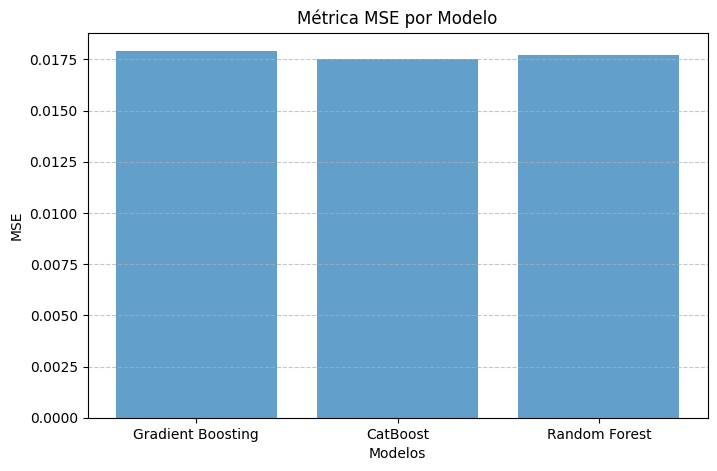

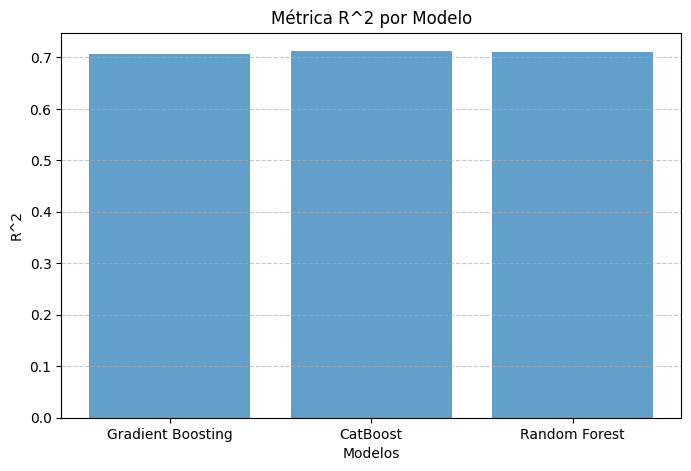

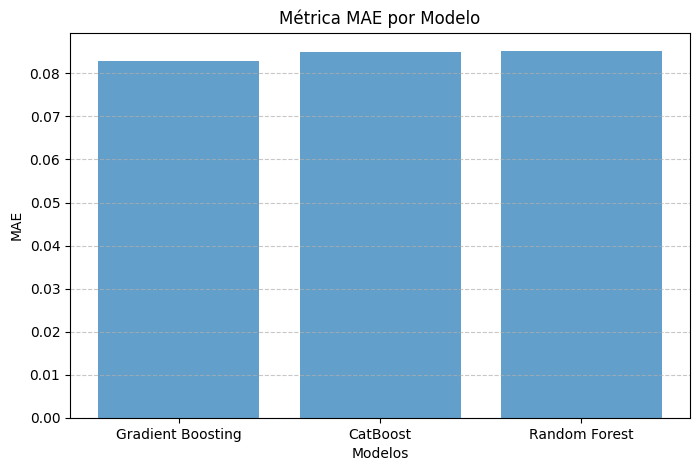

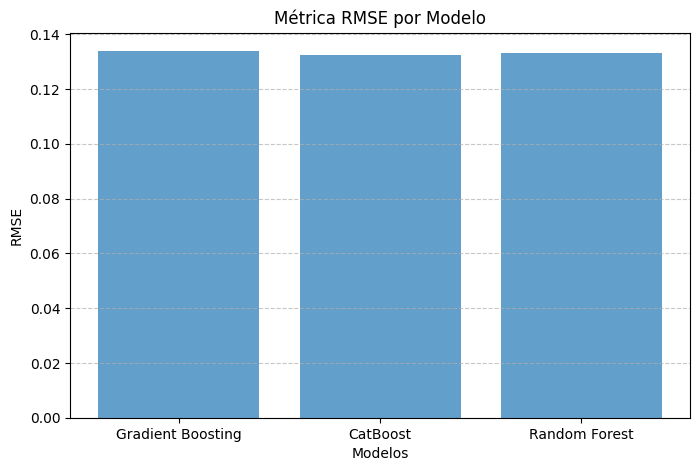

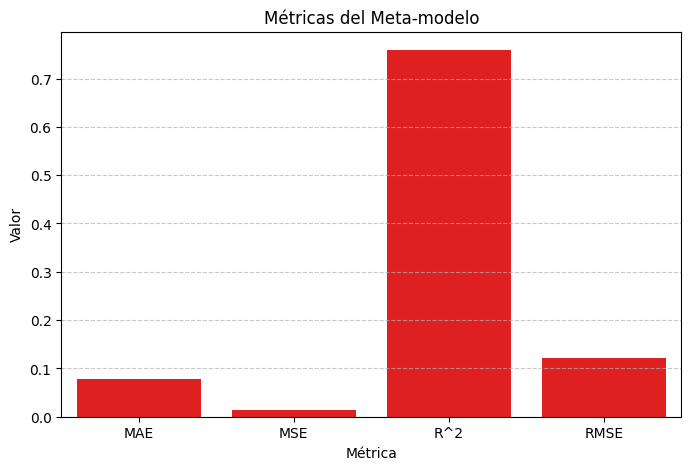


     Actual  Predicted
0      23.0  26.782486
1      73.0  65.046409
2      48.0  50.220835
3      31.0  29.333169
4      41.0  65.416227
..      ...        ...
109    41.0  41.859523
110    38.0  37.974294
111    51.0  62.274721
112    17.0  18.055227
113    25.0  19.730684

[114 rows x 2 columns]



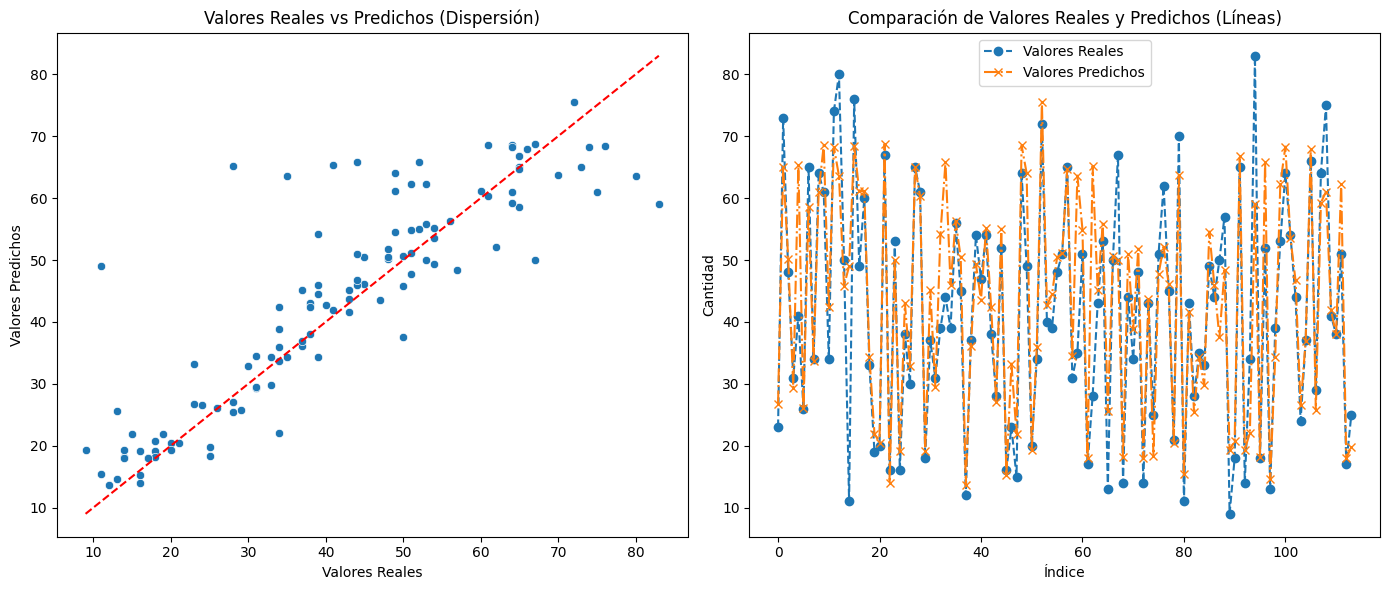

In [ ]:
# 7. Métricas de evaluación
# Métricas de cada modelo base
base_models = {
    'Gradient Boosting': stacking_model.named_estimators_['gb'],
    'CatBoost': stacking_model.named_estimators_['catboost'],
    'Random Forest': stacking_model.named_estimators_['rf']
}

# Calcular métricas para cada modelo base
model_metrics = {}
for model_name, model in base_models.items():
    y_pred_base = model.predict(X_test_scaled)
    mse_base = mean_squared_error(y_test, y_pred_base)
    mse_normalizado = mse_base / ((y_test.max() - y_test.min())**2)
    r2_base = r2_score(y_test, y_pred_base)
    mae_base = mean_absolute_error(y_test, y_pred_base)
    mae_normalizado = mae_base / (y_test.max() - y_test.min())
    rmse_base = np.sqrt(mse_base)
    rmse_normalizado = rmse_base / (y_test.max() - y_test.min())

    print(f"Métricas para {model_name}:")
    print(f"  Mean Squared Error (MSE): {mse_normalizado:.4f}")
    print(f"  R^2 Score: {r2_base:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae_normalizado:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse_normalizado:.4f}\n")

    model_metrics[model_name] = {
        'MSE': mse_normalizado,
        'R^2': r2_base,
        'MAE': mae_normalizado,
        'RMSE': rmse_normalizado
    }

# Métricas de evaluación de la salida del Stacking (Salida del Meta-modelo)
meta_mse = mean_squared_error(y_test, y_pred)
meta_r2 = r2_score(y_test, y_pred)
meta_mae = mean_absolute_error(y_test, y_pred)
meta_rmse = np.sqrt(meta_mse)

# Normalizar las métricas de la salida del Stacking
meta_mse_normalizado = meta_mse / ((y_test.max() - y_test.min())**2)
meta_rmse_normalizado = meta_rmse / (y_test.max() - y_test.min())
meta_mae_normalizado = meta_mae / (y_test.max() - y_test.min())
meta_metricas = {'MAE':meta_mae_normalizado, 'MSE':meta_mse_normalizado, 'R^2':meta_r2, 'RMSE':meta_rmse_normalizado}

# Mostrar las métricas del Stacking
print("Métricas del Stacking (Salida del Meta-modelo):")
print(f"  Mean Squared Error (MSE): {meta_mse_normalizado:.4f}")
print(f"  R^2 Score: {meta_r2:.4f}")
print(f"  Root Mean Squared Error (RMSE): {meta_rmse_normalizado:.4f}")
print(f"  Mean Absolute Error (MAE): {meta_mae_normalizado:.4f}\n")


# Gráficas de las métricas de los modelos base
metrics = ['MSE', 'R^2', 'MAE', 'RMSE']
for metric in metrics:
    values = [model_metrics[model][metric] for model in model_metrics]
    plt.figure(figsize=(8, 5))
    plt.bar(model_metrics.keys(), values, alpha=0.7)
    plt.title(f'Métrica {metric} por Modelo')
    plt.ylabel(metric)
    plt.xlabel('Modelos')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Dataframe para las metricas del Stacking (Salida del meta-modelo)
meta_metricas_df = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'R^2', 'RMSE'],
    'Valor': [meta_mae_normalizado, meta_mse_normalizado, meta_r2, meta_rmse_normalizado]
})

meta_metricas_df = pd.DataFrame(list(meta_metricas.items()), columns=['Métrica', 'Valor'])

# Graficar las metricas del Stacking
plt.figure(figsize=(8, 5))
sns.barplot(x='Métrica', y='Valor', data=meta_metricas_df, errorbar=None, color='red')
plt.title('Métricas del Meta-modelo')
plt.ylabel('Valor')
plt.xlabel('Métrica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Comparar los valores reales vs predichos
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).reset_index(drop=True)
print()
print(comparison)
print()

# Configurar las gráficas
plt.figure(figsize=(14, 6))

# Gráfico de dispersión
plt.subplot(1, 2, 1)
sns.scatterplot(x=comparison['Actual'], y=comparison['Predicted'])
plt.plot([comparison['Actual'].min(), comparison['Actual'].max()],
         [comparison['Actual'].min(), comparison['Actual'].max()],
         color='red', linestyle='--')
plt.title('Valores Reales vs Predichos (Dispersión)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')

# Gráfico de líneas
plt.subplot(1, 2, 2)
plt.plot(comparison['Actual'].values, label='Valores Reales', marker='o', linestyle='--')
plt.plot(comparison['Predicted'].values, label='Valores Predichos', marker='x', linestyle='-.')
plt.title('Comparación de Valores Reales y Predichos (Líneas)')
plt.xlabel('Índice')
plt.ylabel('Cantidad')
plt.legend()

plt.tight_layout()
plt.show()

# **PREDICCIÓN POR CADA AÑO**

     Year  Actual  Predicted      fecha         campo
12   2017    16.0       15.0 2017-01-01     SEHS ANOP
13   2017    18.0       17.0 2017-02-01     SEHS ANOP
14   2017    18.0       20.0 2017-03-01     SEHS ANOP
15   2017    24.0       27.0 2017-04-01     SEHS ANOP
16   2017    29.0       30.0 2017-05-01     SEHS ANOP
..    ...     ...        ...        ...           ...
566  2023    28.0       65.0 2023-08-01  SEHS-CENTRAL
567  2023    52.0       68.0 2023-09-01  SEHS-CENTRAL
568  2023    95.0       67.0 2023-10-01  SEHS-CENTRAL
569  2023    84.0       67.0 2023-11-01  SEHS-CENTRAL
570  2023    51.0       64.0 2023-12-01  SEHS-CENTRAL

[498 rows x 5 columns]
    Year         campo  Actual  Predicted
0   2017     SEHS ANOP    33.0       34.0
1   2017     SEHS APCE    34.0       34.0
2   2017    SEHS MICOP    36.0       35.0
3   2017      SEHS MNO    35.0       34.0
4   2017      SEHS MPN    33.0       34.0
5   2017  SEHS-CENTRAL    35.0       34.0
6   2018     SEHS ANOP    32.0    

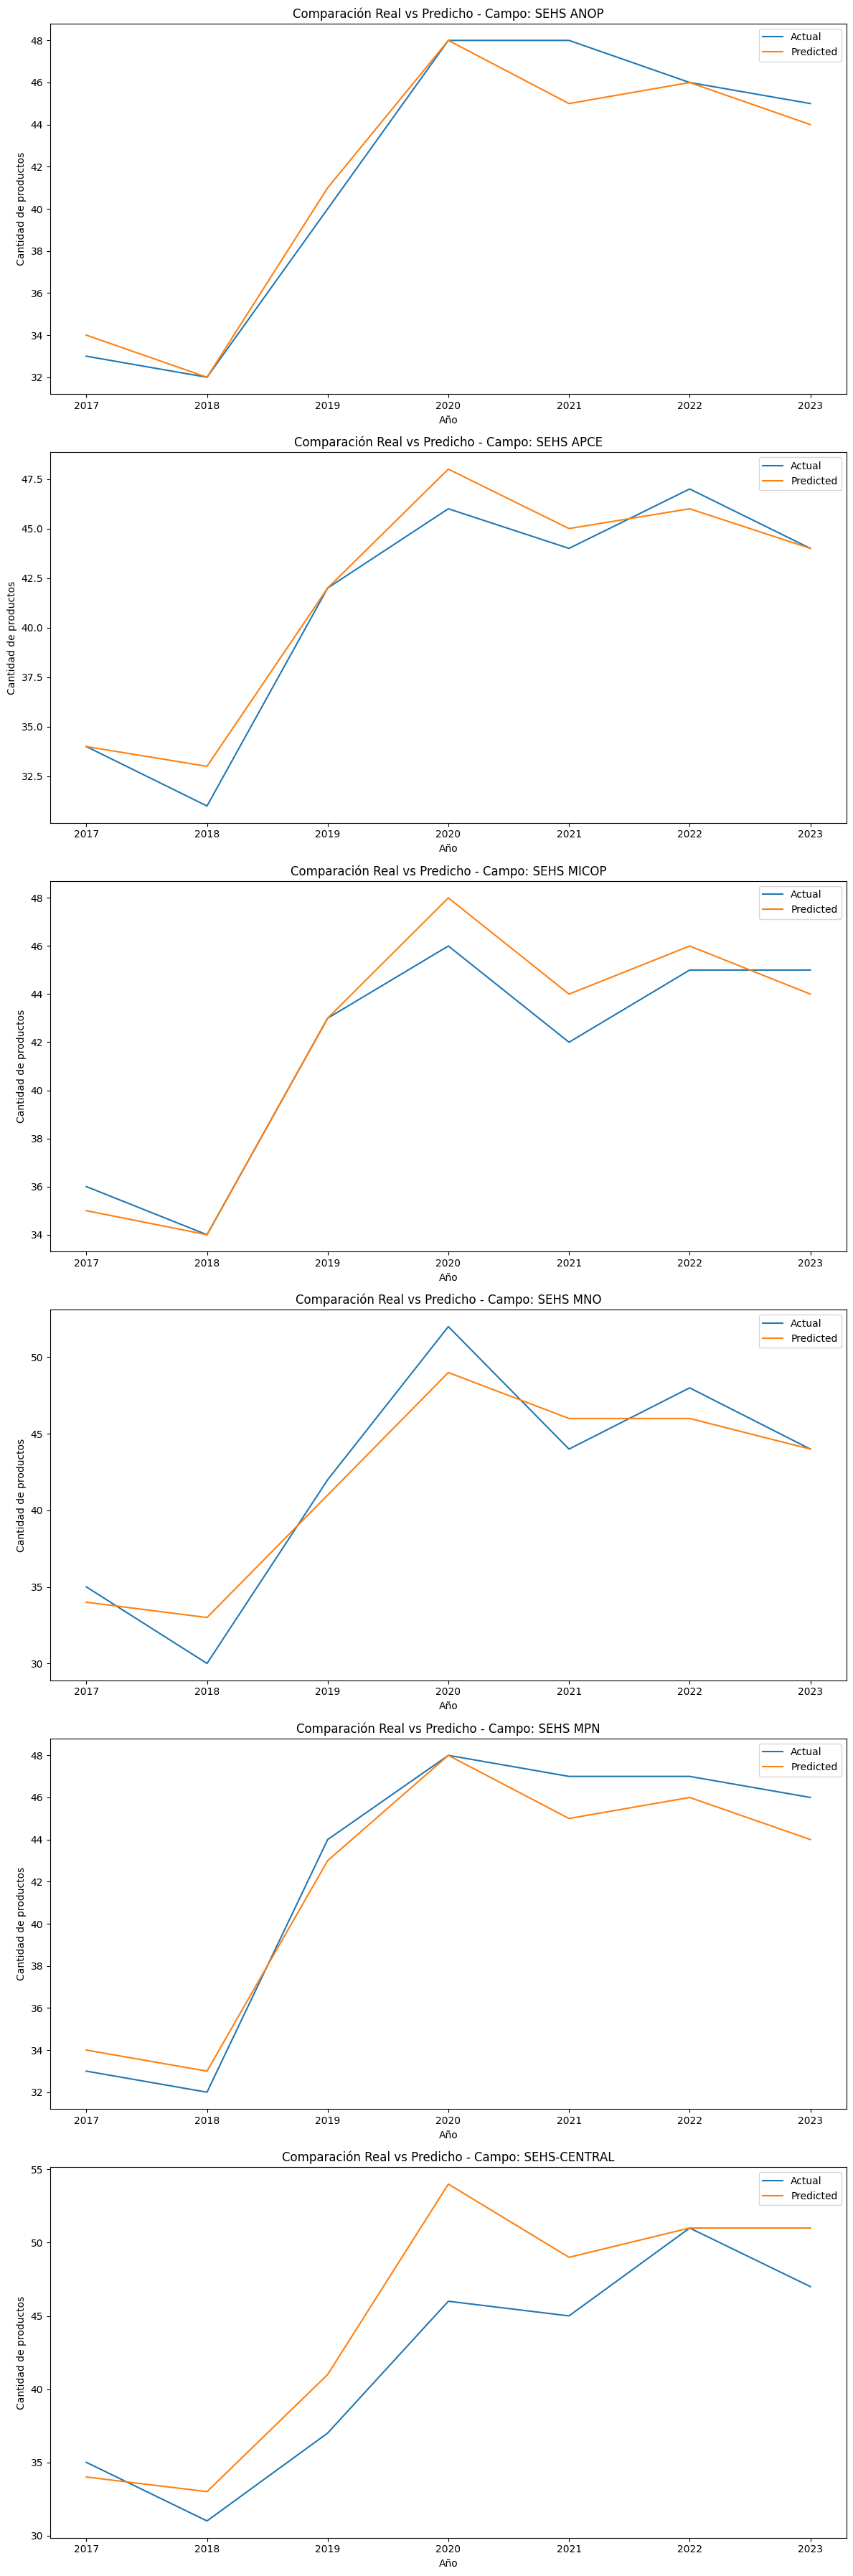

In [ ]:
df_test['campo_Original'] = None

campos_cols = [col for col in df_test.columns if col.startswith('campo_')]

for idx, row in df_test.iterrows():
    for col in campos_cols:
        if row[col] == 1:
            df_test.at[idx, 'campo_Original'] = col.replace('campo_', '')
            break

df_promedio_campo['campo_Original'] = df_promedio_campo['campo']

years = range(2017, 2024)
comparison_results = []

for year in years:
    df_year = df_encoded[df_encoded['Year'] == year]
    X_test = df_year.drop(columns=['cantidad', 'fecha'])
    y_test = df_year['cantidad']

    # Escalar datos de prueba
    scaler = StandardScaler().fit(X)
    X_test_scaled = scaler.transform(X_test)
    y_pred = stacking_model.predict(X_test_scaled)

    # Almacenar resultados
    comparison = pd.DataFrame({
        'Year': [year] * len(y_test),
        'Actual': y_test,
        'Predicted': y_pred
    })
    comparison = pd.merge(comparison, df_promedio_campo[df_promedio_campo['fecha'].dt.year == year][['fecha','campo']], left_index=True, right_index=True, how='left')
    comparison_results.append(comparison)

# Unir todos los resultados
final_comparison = pd.concat(comparison_results).round(0)
print(final_comparison)

final_comparison.to_excel('predicciones_comparacion_inventario2.xlsx', index=False)

# Calcular cantidad promedio real y predicha por año y campo
avg_comparison = final_comparison.groupby(['Year', 'campo']).agg({
    'Actual': 'mean',
    'Predicted': 'mean'
}).reset_index().round(0)

print(avg_comparison)

# Graficar comparaciones por año y campo
campos = df_promedio_campo['campo'].unique()
fig, axes = plt.subplots(nrows=len(campos), figsize=(12, 6 * len(campos)))

for i, campo in enumerate(campos):
    campo_data = avg_comparison[avg_comparison['campo'] == campo]

    sns.lineplot(data=campo_data, x='Year', y='Actual', label='Actual', ax=axes[i], errorbar=None)
    sns.lineplot(data=campo_data, x='Year', y='Predicted', label='Predicted', ax=axes[i], errorbar=None)

    axes[i].set_title(f'Comparación Real vs Predicho - Campo: {campo}')
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('Cantidad de productos')

plt.tight_layout()
plt.show()

# **PREDICCIÓN PARA EL AÑO 2024**

        fecha  Volatilidad_predicha
0  2024-01-01             91.055874
1  2024-02-01             77.581019
2  2024-03-01             59.309338
3  2024-04-01             60.102585
4  2024-05-01             61.267364
..        ...                   ...
67 2024-08-01             73.436600
68 2024-09-01             70.441587
69 2024-10-01             65.761102
70 2024-11-01             63.430047
71 2024-12-01             64.648643

[72 rows x 2 columns]


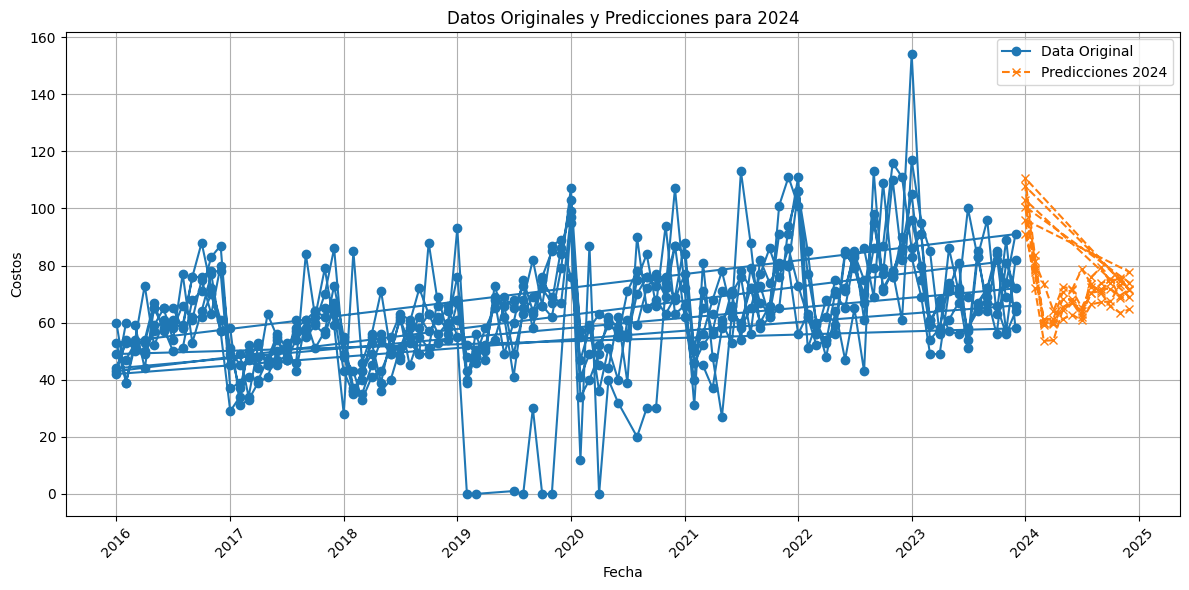

In [ ]:
# Crear datos futuros para el año 2024
unique_campos = volatility_campo['campo'].unique()
future_dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

# Crear una lista para almacenar los datos futuros de cada 'campo'
all_future_data = []

# Iterar a través de cada 'campo' único para crear datos para 2024
for campo in unique_campos:
    future_data = pd.DataFrame({
        'fecha': pd.to_datetime(future_dates),
        'Year': future_dates.year,
        'Month': future_dates.month,
        'campo': campo  # Agregar la columna 'campo' aquí
    })
    all_future_data.append(future_data)

# Concatenar todos los datos futuros en un solo DataFrame
future_data = pd.concat(all_future_data, ignore_index=True)

# Obtener las columnas originales utilizadas durante el entrenamiento (asumiendo que se utilizó X_train_scaled)
original_columns = X_train.columns

# Crear variables dummy para la columna 'campo' y alinearlas con las columnas originales
future_data = pd.get_dummies(future_data, columns=['campo'], prefix=['campo'], prefix_sep='_')

# Asegurarse de que future_data tenga las mismas columnas que los datos originales
missing_cols = set(original_columns) - set(future_data.columns)
for col in missing_cols:
    future_data[col] = 0  # Agregar las columnas faltantes y rellenarlas con ceros

# Reordenar las columnas para que coincidan con las columnas originales, manteniendo 'fecha'
future_data_reordered = future_data[original_columns] # Seleccionar columnas para el modelo
future_data['Volatilidad_predicha'] = best_model.predict(scaler.transform(future_data_reordered)) # Predecir usando datos reordenados y transformados
future_results = future_data[['fecha', 'Volatilidad_predicha']] # Seleccionar columnas del DataFrame futuro que incluyan 'fecha'



# Mostrar las predicciones
print(future_results)

# Concatenar data original con predicciones para graficar
historical_data = volatility_campo[['fecha', 'costos']].rename(columns={'costos': 'Volatilidad_real'})
combined_data = pd.concat([
    historical_data,
    future_results.rename(columns={'Volatilidad_predicha': 'Volatilidad_real'})
])

# Graficar data original y predicciones
plt.figure(figsize=(12, 6))
plt.plot(historical_data['fecha'], historical_data['Volatilidad_real'], label='Data Original', marker='o', linestyle='-')
plt.plot(future_results['fecha'], future_results['Volatilidad_predicha'], label='Predicciones 2024', marker='x', linestyle='--')
plt.title('Datos Originales y Predicciones para 2024')
plt.xlabel('Fecha')
plt.ylabel('Costos')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()